In [212]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, accuracy_score,classification_report, precision_recall_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%matplotlib inline
from pandas.plotting import scatter_matrix
from collections import Counter

In [19]:
df=pd.read_csv('data/Telco_Customer_Churn.csv')

In [20]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [35]:
df.shape

(7043, 21)

In [21]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [22]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [255]:
# Replace spaces wtih null value
df_copy=df.copy()
df_copy['TotalCharges']=df_copy['TotalCharges'].replace(" ",np.nan)
df_copy['TotalCharges']

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [256]:
df_copy.dropna(inplace=True)

In [257]:
df_copy.shape

(7032, 21)

In [258]:
df_copy['TotalCharges']=pd.to_numeric(df_copy['TotalCharges'])

In [259]:
df_copy.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [260]:
# Consider 'No internet service' as 'No'
replace_columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_columns:
    df_copy[i]=df_copy[i].replace('No internet service', 'No')
df_copy['MultipleLines']=df_copy['MultipleLines'].replace('No phone service', 'No')
df_copy

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService MultipleLines InternetService OnlineSecurity  ...  \
0              No            No             DSL             No  ...   
1             Yes            No             DSL            Yes  ...   
2             Yes            No             DSL            Yes  ...   
3              No            No             DSL            Yes  ...   
4             Yes            No     Fiber optic             No  ...   
...           ...           ...             ...            ...  ...   
7038          Yes           Yes             DSL            Yes  ...   
7039          Yes           Yes     Fiber optic             No  ...   
7040           No            No             DSL            Yes  ...   
7041          Yes           Yes     Fiber optic             No  ...   
7042          Yes            No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95       1889.50   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80       1990.50   
7039              Yes    Credit card (automatic)         103.20       7362.90   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40        306.60   
7042              Yes  Bank transfer (automatic)         105.65       6844.50   

      Churn  
0        No  
1        No  
2       Yes  
3        No  
4       Yes  
...     ...  
7038     No  
7039     No  
7040     No  
7041    Yes  
7042     No  

[7032 rows x 21 columns]

# EDA

No     5163
Yes    1869
Name: Churn, dtype: int64


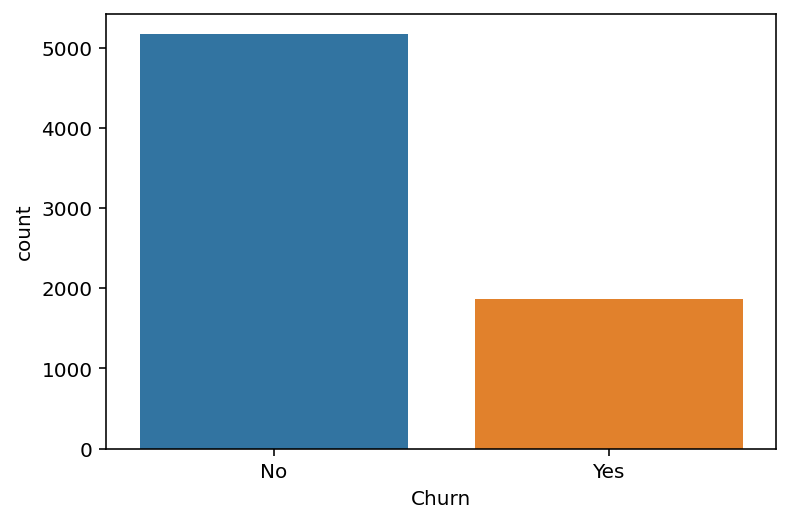

In [262]:
# Target distribution
sns.countplot('Churn',data=df_copy)
print(df_copy.Churn.value_counts())

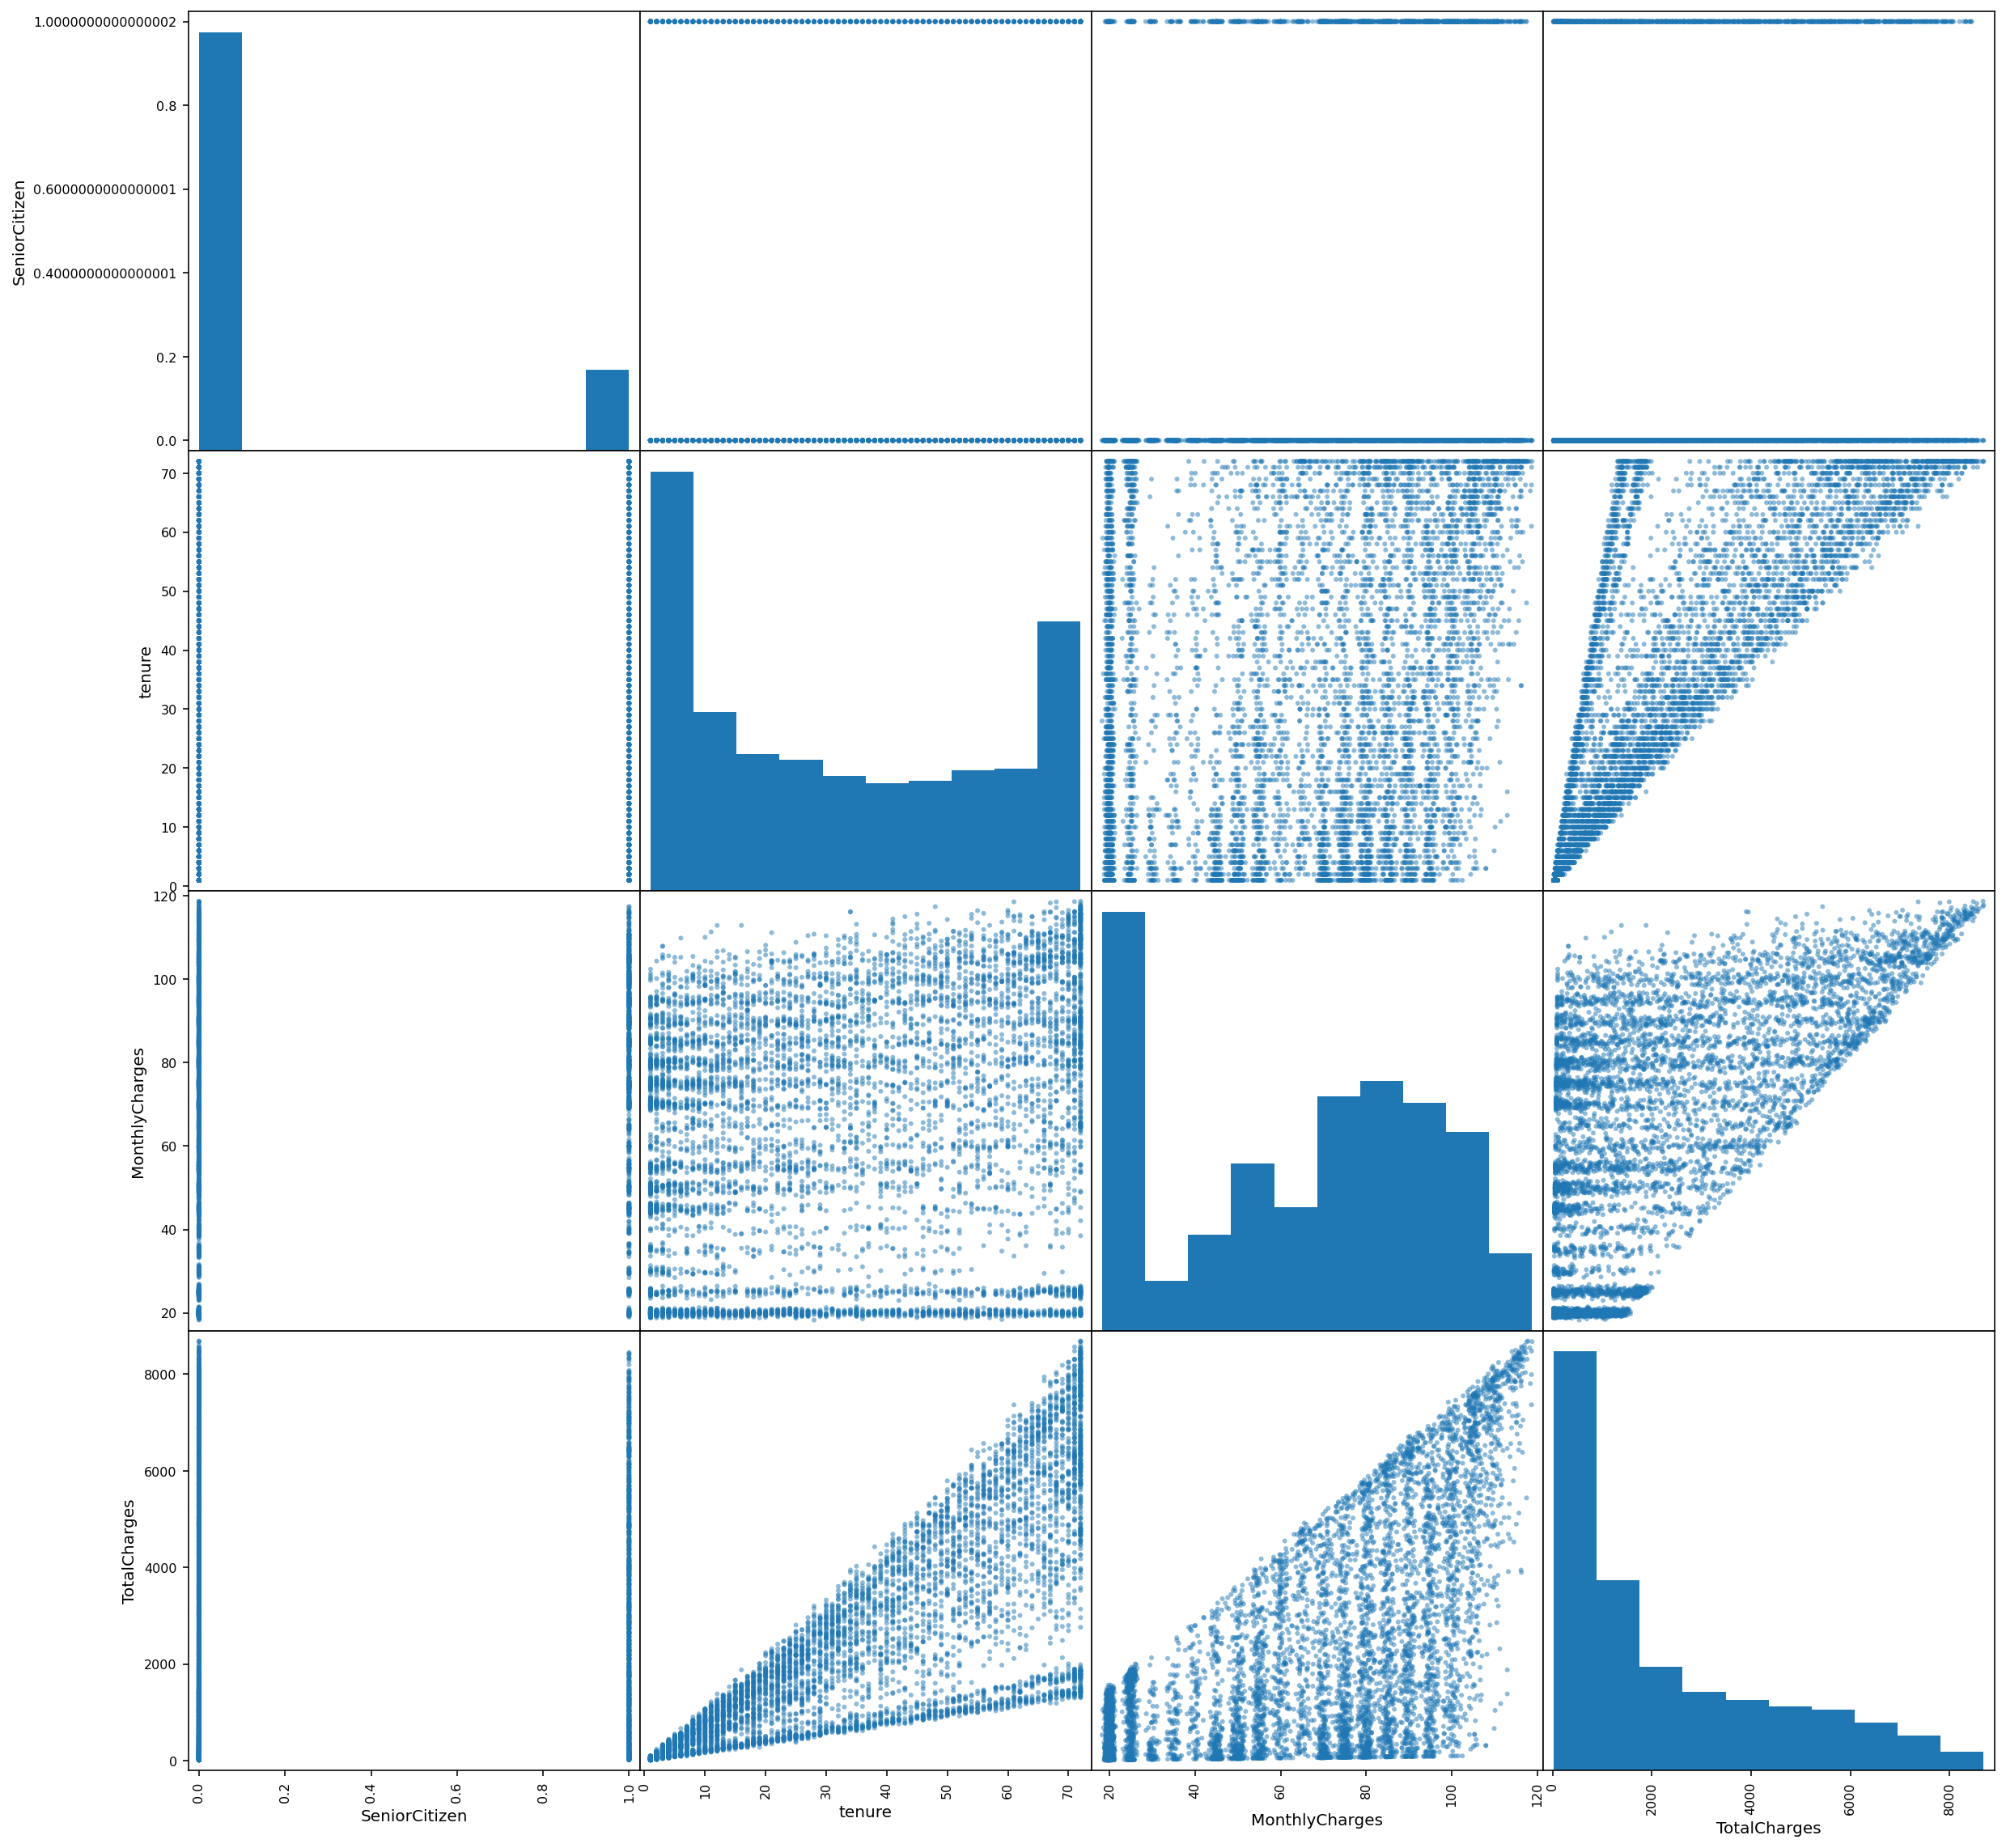

In [261]:
p=scatter_matrix(df_copy, figsize=(20,20))

In [215]:
import matplotlib.pyplot as plt
# A very first look into the data
f,ax = plt.subplots(3,4,figsize=(20,16))
sns.countplot('SeniorCitizen',data=df_copy,ax=ax[0,0])
sns.countplot('gender',data=df_copy,ax=ax[0,1])
sns.boxplot(x='SeniorCitizen',y='tenure',data=df_copy,ax=ax[0,2])
sns.countplot('tenure',hue='Churn',data=df_copy,ax=ax[0,3],palette='husl')

sns.countplot('SeniorCitizen',hue='Churn',data=df_copy,ax=ax[1,0],palette='husl')
sns.countplot('gender',hue='Churn',data=df_copy,ax=ax[1,1],palette='husl')
sns.distplot(df_copy[df_copy['Churn']==0]['TotalCharges'].dropna(),ax=ax[1,2],kde=False,color='r',bins=5)
sns.distplot(df_copy[df_copy['Churn']==1]['TotalCharges'].dropna(),ax=ax[1,2],kde=False,color='g',bins=5)
sns.countplot('TotalCharges',hue='gender',data=df_copy,ax=ax[1,3],palette='husl')

sns.distplot(df_copy['MonthlyCharges'],ax=ax[2,0],kde=False,color='b')
sns.swarmplot(x='tenure',y='MonthlyCharges',hue='Churn',data=df_copy,palette='husl',ax=ax[2,1])
sns.distplot(df_copy['TotalCharges'],ax=ax[2,2],kde=False,color='b')
sns.countplot('PaymentMethod',hue='Churn',data=df_copy,ax=ax[2,3],palette='husl')


ax[0,0].set_title('Total Customer by SeniorCitizen')
ax[0,1].set_title('Total Customer by Gender')
ax[0,2].set_title('Tenure Box Plot By SeniorCitizen')
ax[0,3].set_title('Churn by Tenure')
ax[1,0].set_title('Churn by SeniorCitizen')
ax[1,1].set_title('Churn by Gender')
ax[1,2].set_title('Churn by TotalCharges')
ax[1,3].set_title('TotalCharges by Gender')
ax[2,0].set_title('MonthlyCharges Distribution')
ax[2,1].set_title('Churn by tenure and MonthlyCharges')
ax[2,2].set_title('TotalCharges Distribution')
ax[2,3].set_title('Churn by PaymentMethod')



"\nax[0,0].set_title('Total Passengers by Class')\nax[0,1].set_title('Total Passengers by Gender')\nax[0,2].set_title('Age Box Plot By Class')\nax[0,3].set_title('Survival Rate by SibSp')\nax[1,0].set_title('Survival Rate by Class')\nax[1,1].set_title('Survival Rate by Gender')\nax[1,2].set_title('Survival Rate by Age')\nax[1,3].set_title('Survival Rate by Parch')\nax[2,0].set_title('Fare Distribution')\nax[2,1].set_title('Survival Rate by Fare and Pclass')\nax[2,2].set_title('Total Passengers by Embarked')\nax[2,3].set_title('Survival Rate by Embarked')\n"

In [263]:
# Outlier detection 
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index       
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   
# detect outliers from "tenure","MonthlyCharges","TotalCharges"
Outliers_to_drop = detect_outliers(df_copy,2,["tenure","MonthlyCharges","TotalCharges"])
df_copy.loc[Outliers_to_drop] # Show the outliers rows

Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]

# Data preprossing

In [265]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [299]:
df_prep=df_copy.copy()
bin_cols   = df_prep.nunique()[df_prep.nunique() == 2].keys().tolist()
bin_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'Churn']

In [300]:
le = LabelEncoder()
for i in bin_cols :
    df_prep[i] = le.fit_transform(df_prep[i])

In [343]:
df_prep.head()

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0              0        1           0       1   
1  5575-GNVDE       1              0        0           0      34   
2  3668-QPYBK       1              0        0           0       2   
3  7795-CFOCW       1              0        0           0      45   
4  9237-HQITU       0              0        0           0       2   

   PhoneService  MultipleLines  OnlineSecurity  OnlineBackup  ...  \
0             0              0               0             1  ...   
1             1              0               1             0  ...   
2             1              0               1             1  ...   
3             0              0               1             0  ...   
4             1              0               0             0  ...   

   InternetService_DSL  InternetService_Fiber optic  InternetService_No  \
0                    1                            0                   0   
1                    1                            0                   0   
2                    1                            0                   0   
3                    1                            0                   0   
4                    0                            1                   0   

   Contract_Month-to-month  Contract_One year  Contract_Two year  \
0                        1                  0                  0   
1                        0                  1                  0   
2                        1                  0                  0   
3                        0                  1                  0   
4                        1                  0                  0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 28 columns]

In [302]:
multi_cols = df_prep.nunique()[df_prep.nunique().isin([3,4])].keys().tolist()
multi_cols

['InternetService', 'Contract', 'PaymentMethod']

In [303]:
#df_prep[multi_cols]=df_prep[multi_cols].astype('category')
df_prep = pd.get_dummies(data = df_prep,columns = multi_cols )

In [304]:
df_prep.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7032 non-null   object 
 1   gender                                   7032 non-null   int32  
 2   SeniorCitizen                            7032 non-null   int64  
 3   Partner                                  7032 non-null   int32  
 4   Dependents                               7032 non-null   int32  
 5   tenure                                   7032 non-null   int64  
 6   PhoneService                             7032 non-null   int32  
 7   MultipleLines                            7032 non-null   int32  
 8   OnlineSecurity                           7032 non-null   int32  
 9   OnlineBackup                             7032 non-null   int32  
 10  DeviceProtection                         7032 no

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# create correlation in dataframe
corr = df_prep[df_prep.columns[1:]].corr()

plt.figure(figsize=(22, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corr, linewidths=0.1,vmax=1.0, square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True);

# Model Build

In [358]:
# Machine learning libraries
import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics

import sklearn         # Collection of machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix

In [338]:
label=df_prep.Churn
df_train=df_prep.drop(columns=['customerID','Churn'])

X_train, x_test, Y_train, y_test = train_test_split(df_train, label, stratify = label, test_size = .25 ,random_state = 23)

# Baseline model - Logistic Regression

In [342]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred1 = logreg.predict(x_test)
acc_log = round(logreg.score(x_test, y_test) * 100, 2)
acc_log

80.66

In [345]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, Y_pred1))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred1), ['Actual: NOT', 'Actual: Yes'], ['Predicted: NOT', 'Predicted: Yes'])
print(cm)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1291
           1       0.67      0.53      0.59       467

    accuracy                           0.81      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.80      0.81      0.80      1758

             Predicted: NOT  Predicted: Yes
Actual: NOT            1171             120
Actual: Yes             220             247


In [347]:
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Score"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Score', ascending=False)

Feature     Score
19                        Contract_One year  0.428031
17                       InternetService_No  0.397402
13                           MonthlyCharges  0.365724
1                                   Partner  0.250960
12                         PaperlessBilling  0.186699
6                            OnlineSecurity  0.170018
24               PaymentMethod_Mailed check  0.157529
11                          StreamingMovies  0.098209
14                             TotalCharges  0.008427
2                                Dependents  0.007861
15                      InternetService_DSL  0.000300
4                              PhoneService -0.058356
0                             SeniorCitizen -0.075871
16              InternetService_Fiber optic -0.083883
9                               TechSupport -0.115075
23           PaymentMethod_Electronic check -0.119600
22    PaymentMethod_Credit card (automatic) -0.163526
20                        Contract_Two year -0.169885
3                                    tenure -0.175618
8                          DeviceProtection -0.262546
10                              StreamingTV -0.466665
7                              OnlineBackup -0.476950
21  PaymentMethod_Bank transfer (automatic) -0.605738
18                  Contract_Month-to-month -0.661112
5                             MultipleLines -0.694283

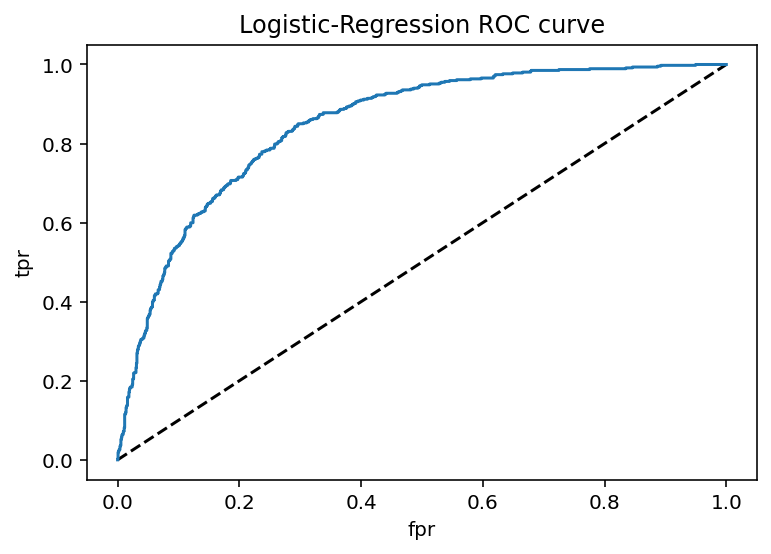

Train Score:0.81
Test Score:0.81
ROC Score: 0.85


In [354]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba1 = logreg.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic-Regression')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Logistic-Regression ROC curve')
plt.show()
#Area under ROC curve
print("Train Score:{:.2f}".format(logreg.score(X_train,Y_train)))
print("Test Score:{:.2f}".format(logreg.score(x_test,y_test)))
print("ROC Score: {:.2f}".format(roc_auc_score(y_test,y_pred_proba1)))

In [363]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred2 = decision_tree.predict(x_test)
acc_decision_tree = round(decision_tree.score(x_test, y_test) * 100, 2)
acc_decision_tree

73.04

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1291
           1       0.49      0.53      0.51       467

    accuracy                           0.73      1758
   macro avg       0.66      0.67      0.66      1758
weighted avg       0.74      0.73      0.73      1758

             Predicted: NO  Predicted: YES
Actual: NOT           1036             255
Actual: YES            219             248


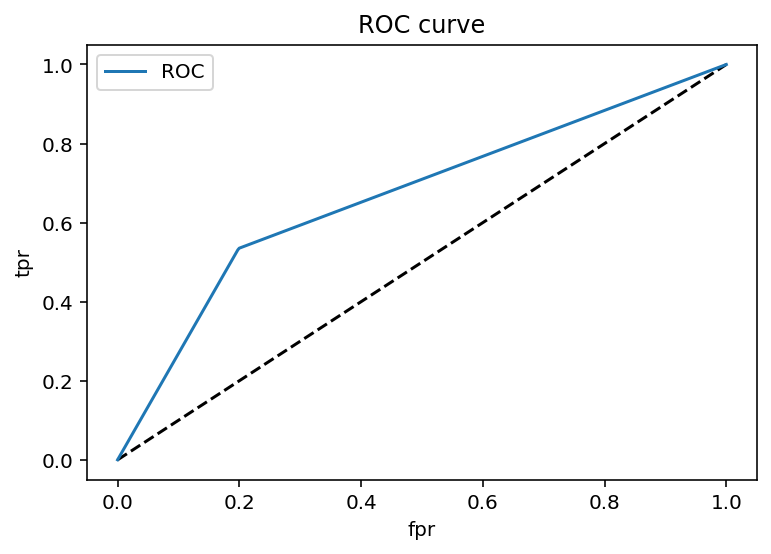

0.6679374752237945

In [364]:
print(classification_report(y_test, Y_pred2))
cm = pd.DataFrame(confusion_matrix(y_test, Y_pred2), ['Actual: NOT', 'Actual: YES'], ['Predicted: NO', 'Predicted: YES'])
print(cm)
y_pred_proba2 = decision_tree.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.legend()
plt.show()
roc_auc_score(y_test,y_pred_proba2)


# Random Forest

In [361]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest_predictions = random_forest.predict(x_test)
acc_random_forest = round(random_forest.score(x_test, y_test) * 100, 2)
acc_random_forest

79.35

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1291
           1       0.66      0.47      0.55       467

    accuracy                           0.79      1758
   macro avg       0.74      0.69      0.71      1758
weighted avg       0.78      0.79      0.78      1758

             Predicted: NO  Predicted: YES
Actual: NOT           1176             115
Actual: YES            248             219


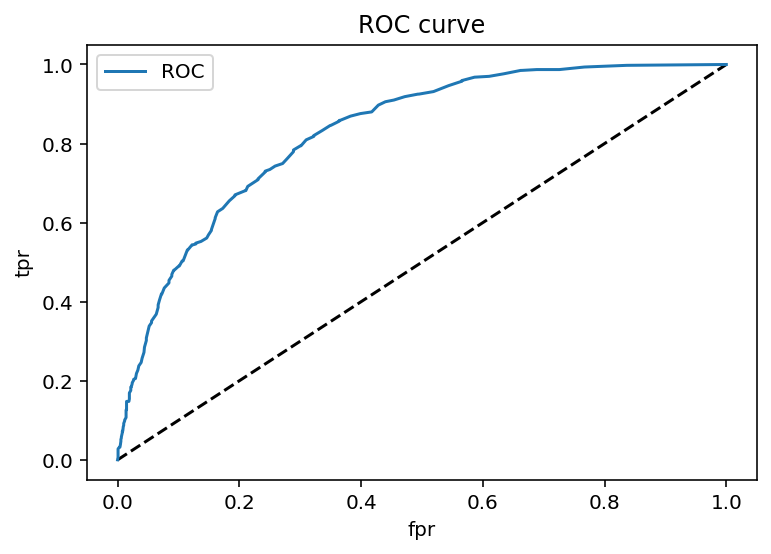

0.8282144379554053

In [362]:
print(classification_report(y_test, random_forest_predictions))
cm = pd.DataFrame(confusion_matrix(y_test, random_forest_predictions), ['Actual: NOT', 'Actual: YES'], ['Predicted: NO', 'Predicted: YES'])
print(cm)
y_pred_proba3 = random_forest.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba3)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.legend()
plt.show()
roc_auc_score(y_test,y_pred_proba3)

# XGBoost

In [371]:
from xgboost import XGBClassifier
xgb =XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb.fit(X_train, Y_train)
xgb_predictions = xgb.predict(x_test)
acc_xgb = round(xgb.score(x_test, y_test) * 100, 2)
acc_xgb

76.85

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1291
           1       0.58      0.46      0.52       467

    accuracy                           0.77      1758
   macro avg       0.70      0.67      0.68      1758
weighted avg       0.76      0.77      0.76      1758

             Predicted: NO  Predicted: YES
Actual: NOT           1134             157
Actual: YES            250             217


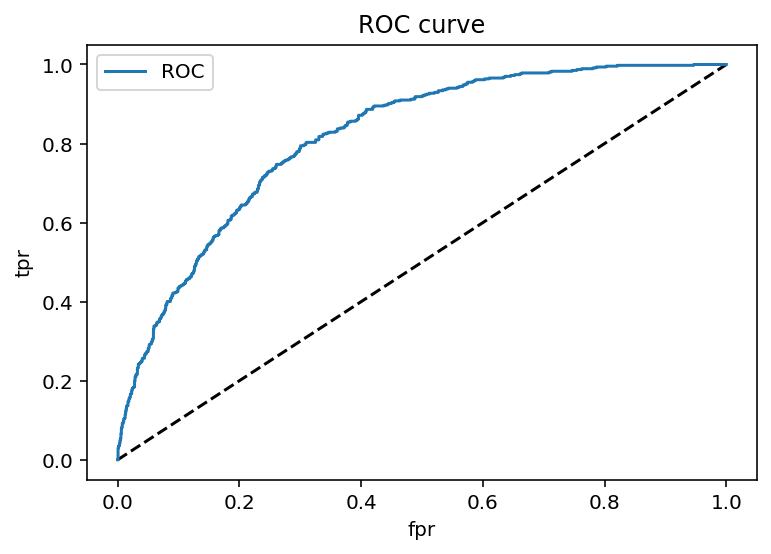

0.8151019162477173

In [372]:
print(classification_report(y_test, xgb_predictions))
cm = pd.DataFrame(confusion_matrix(y_test, xgb_predictions), ['Actual: NOT', 'Actual: YES'], ['Predicted: NO', 'Predicted: YES'])
print(cm)
y_pred_proba4 = xgb.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba4)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.legend()
plt.show()
roc_auc_score(y_test,y_pred_proba4)

# Model Performance

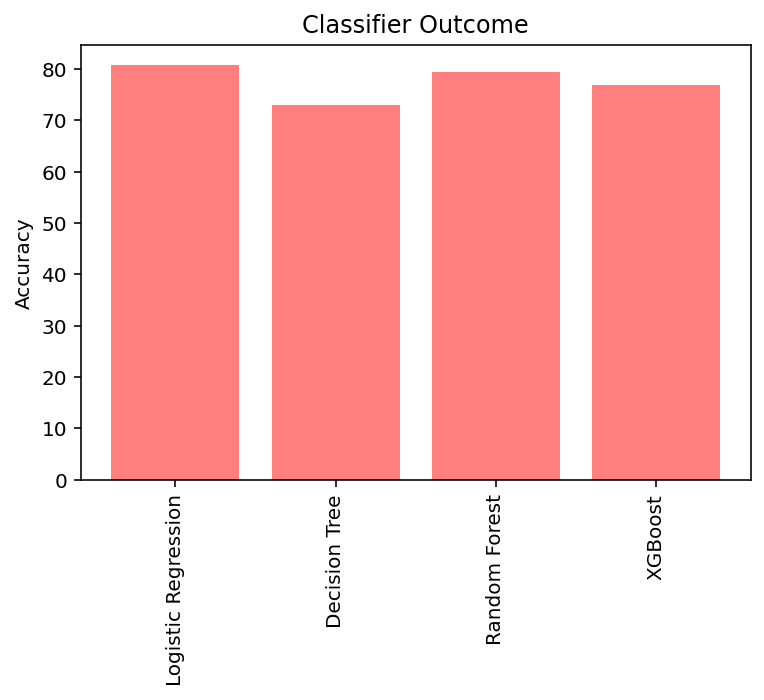

In [432]:
objects = ('Logistic Regression','Decision Tree', 'Random Forest', 'XGBoost')
x_pos = np.arange(len(objects))
accuracies1 = [acc_log, acc_decision_tree, acc_random_forest, acc_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

# Model cross-validation with K-Fold

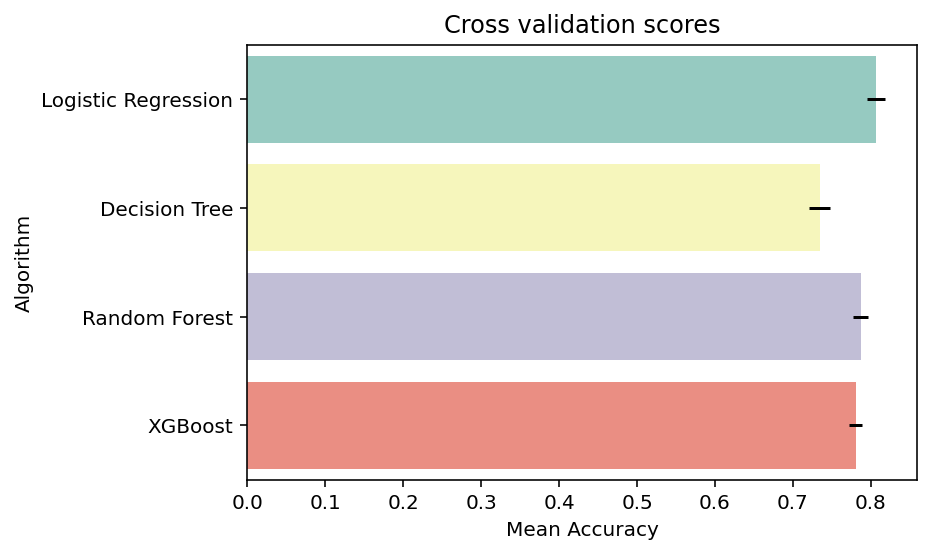

In [433]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)
random_state = 23

classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(XGBClassifier(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

# Hyperparameter tuning

In [436]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [440]:
# Create param grid.

logreg_param_grid = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "penalty": ['l2'],
    "C": [100, 10, 1.0, 0.1, 0.01]
}

gs_logreg = GridSearchCV(logreg,param_grid = logreg_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gs_logreg.fit(X_train,Y_train)
# Best score
logreg_best = gs_logreg.best_estimator_
gs_logreg.best_score_

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   11.8s finished


0.8071653441435224

In [451]:
rf_param_grid = {"max_depth": np.arange(9,10),
              "max_features": [4,5],
              "min_samples_split": [5,6],
              "min_samples_leaf": [7,8],
              "bootstrap": [False,True],
              "n_estimators" :[500,600],
              "criterion": ["gini","entropy"]}
gs_random_forest = GridSearchCV(random_forest,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gs_random_forest.fit(X_train,Y_train)
# Best score
random_forest_best = gs_random_forest.best_estimator_
gs_random_forest.best_score_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 10.8min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed: 14.5min finished


0.8071639066183659

In [452]:
gs_random_forest.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 4,
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 500}

In [459]:
xgb_param_grid = {
    'max_depth':[1,2,3],
    'min_child_weight':[6,7,8],
    'gamma':[i/1000.0 for i in range(0,10,5)],
    'subsample':[i/100.0 for i in range(55,65,5)],
    'colsample_bytree':[i/100.0 for i in range(10,20,5)],
    'reg_alpha':[0,0.01]
}
gs_xgb = GridSearchCV(xgb,param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gs_xgb.fit(X_train,Y_train)
xgb_best = gs_xgb.best_estimator_
gs_xgb.best_score_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 15.6min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 23.7min
[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed: 27.8min finished


0.8026109050658385

In [455]:
gs_xgb.best_params_

{'colsample_bytree': 0.15,
 'gamma': 0.0,
 'max_depth': 1,
 'min_child_weight': 6,
 'reg_alpha': 0,
 'subsample': 0.6}

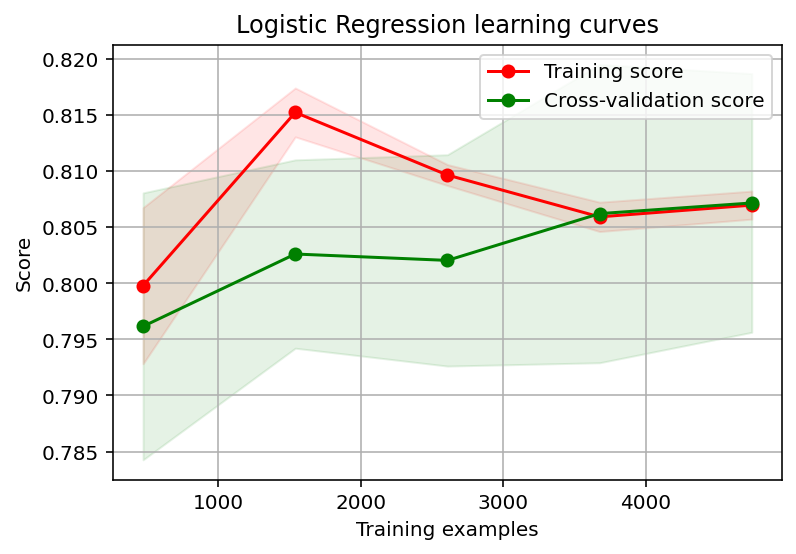

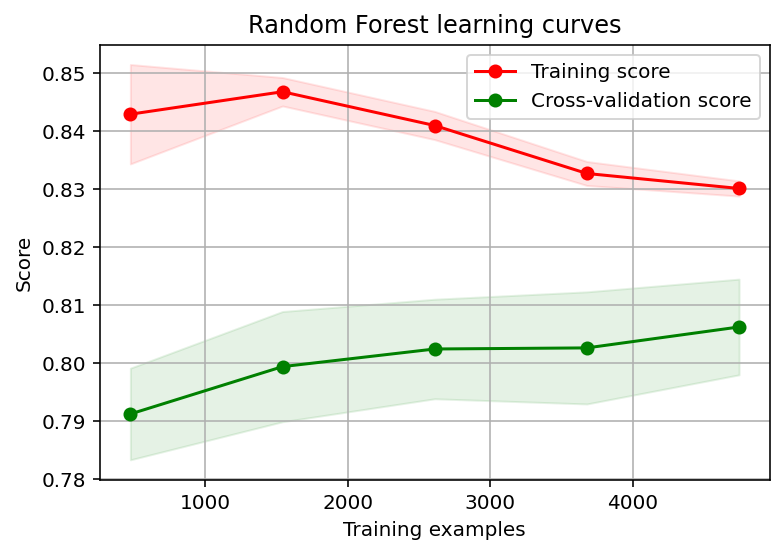

In [456]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gs_logreg.best_estimator_,"Logistic Regression learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gs_random_forest.best_estimator_,"Random Forest learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gs_xgb.best_estimator_,"XGBoost learning curves",X_train,Y_train,cv=kfold)


In [461]:
test_logreg = pd.Series(logreg_best.predict(x_test), name="logistic Regression")
test_rf = pd.Series(random_forest_best.predict(x_test), name="Random Forest")
test_xgb = pd.Series(xgb_best.predict(x_test), name="XGBoost")


# Concatenate all classifier results
ensemble_results = pd.concat([test_logreg, test_rf, test_xgb],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

# Feature Importance

Text(0.5, 1.0, 'Logistic Regression feature importance')

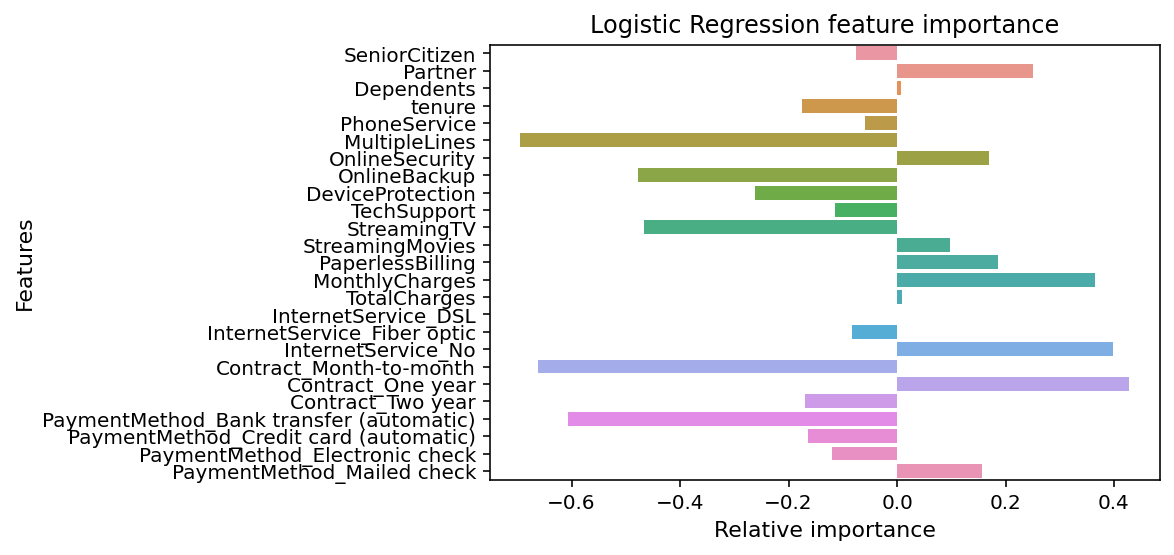

In [479]:
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Score"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Score', ascending=False)
g = sns.barplot(y=coeff_df['Feature'][:40],x = coeff_df["Score"], orient='h')
g.set_xlabel("Relative importance",fontsize=11)
g.set_ylabel("Features",fontsize=11) 
g.set_title( "Logistic Regression feature importance")

In [482]:
indices = np.argsort(random_forest_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = random_forest_best.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=11)
g.set_ylabel("Features",fontsize=11)
g.tick_params(labelsize=9)
g.set_title("Random Forest feature importance")

Text(0.5, 1.0, 'Random Forest feature importance')

Text(0.5, 1.0, 'XGBoost feature importance')

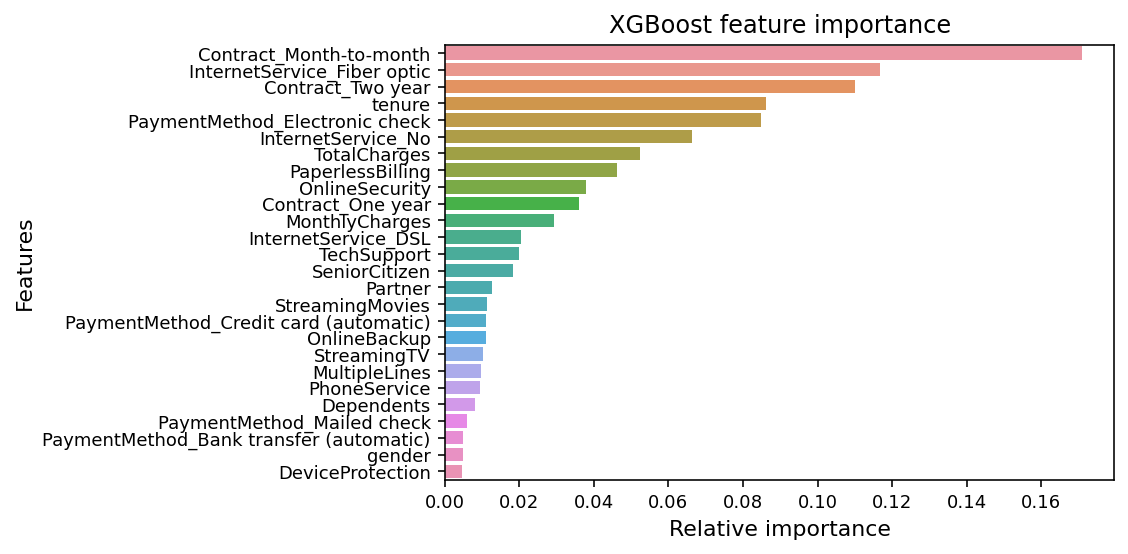

In [481]:
indices = np.argsort(xgb_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = xgb_best.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=11)
g.set_ylabel("Features",fontsize=11)
g.tick_params(labelsize=9)
g.set_title("XGBoost feature importance")

# Appendix

In [388]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=23), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.8446631212751502)

In [390]:
param_test2 = {
 'max_depth':[1,2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, 
                                                  #max_depth=5, min_child_weight=2, 
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, 
                                                  scale_pos_weight=1,seed=23),
                        param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 2, 'min_child_weight': 5}, 0.8473535505423552)

In [391]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=23), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.8473572371782998)

In [399]:
param_test4 = {
 'subsample':[i/10.0 for i in range(5,10)],
 'colsample_bytree':[i/10.0 for i in range(5,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=5, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=23), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.5, 'subsample': 0.7}, 0.8484441091949823)

In [400]:
param_test5 = {
 'subsample':[i/100.0 for i in range(65,85,5)],
 'colsample_bytree':[i/100.0 for i in range(45,65,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=5, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=23), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.55, 'subsample': 0.7}, 0.848679519708346)

In [407]:
param_test6 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=5, gamma=0.2, subsample=0.7, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=23), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0}, 0.848679519708346)

In [410]:
param_test7 = {
 'reg_alpha':[0, 1e-05, 1e-03, 1e-01]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
 min_child_weight=5, gamma=0.2, subsample=0.7, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=23), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,Y_train)
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 0}, 0.848679519708346)

In [420]:
params = {
    'max_depth':[1,2,3],
    'min_child_weight':[6,7,8],
    'gamma':[i/1000.0 for i in range(0,10,5)],
    'subsample':[i/100.0 for i in range(55,65,5)],
    'colsample_bytree':[i/100.0 for i in range(15,25,5)],
    'reg_alpha':[0]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=23), 
 param_grid = params, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch.fit(X_train,Y_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.2,
  'gamma': 0.0,
  'max_depth': 2,
  'min_child_weight': 6,
  'reg_alpha': 0,
  'subsample': 0.6},
 0.8485845310039591)

In [423]:
best_model=gsearch.best_estimator_

In [424]:
best_model.fit(X_train, Y_train)
best_model_predictions = best_model.predict(x_test)
acc_best_model = round(best_model.score(x_test, y_test) * 100, 2)
acc_best_model

80.38

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1291
           1       0.67      0.51      0.58       467

    accuracy                           0.80      1758
   macro avg       0.75      0.71      0.73      1758
weighted avg       0.79      0.80      0.79      1758

             Predicted: NO  Predicted: YES
Actual: NOT           1176             115
Actual: YES            230             237


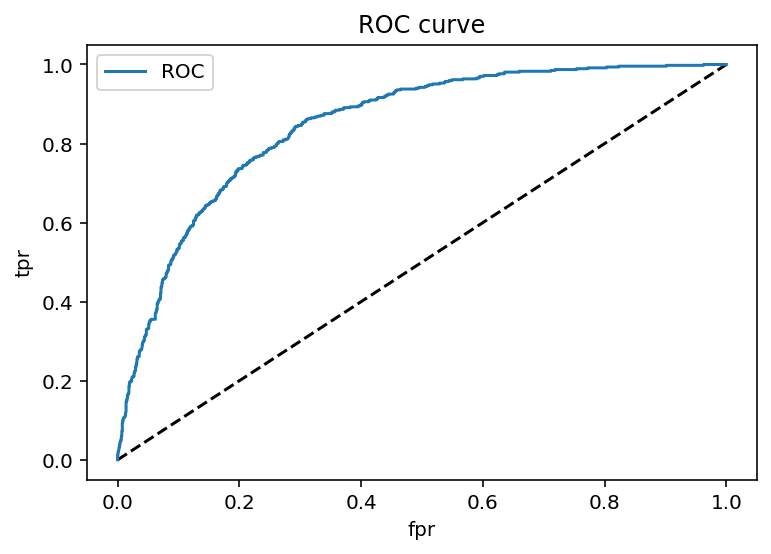

0.847012010343392

In [425]:
print(classification_report(y_test, best_model_predictions))
cm = pd.DataFrame(confusion_matrix(y_test, best_model_predictions), ['Actual: NOT', 'Actual: YES'], ['Predicted: NO', 'Predicted: YES'])
print(cm)
y_pred_proba5 = best_model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba5)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.legend()
plt.show()
roc_auc_score(y_test,y_pred_proba5)